<a href="https://colab.research.google.com/github/Jeon1301/Test/blob/main/221215_finals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 적대적 예제 생성

**구현**

In [19]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

**입력**

In [20]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

**공격 받는 모델**

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) 
                       else "cpu")

CUDA Available:  True


In [22]:
model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model.eval()

FileNotFoundError: ignored

오류가 난 부분은 '미리 학습된 모델을 읽어오기' 부분인데

https://github.com/pytorch/vision/issues/3497
참고해 확인한 결과

colab googlecolab/colabtools#1889 에서 torchvision으로 더 이상 MNIST 데이터세트를 다운로드할 수 없다고 나와있습니다.

**FGSM 공격**

In [23]:
def fgsm_attack(image, epsilon, data_grad):
    
    sign_data_grad = data_grad.sign()
    
    perturbed_image = image + epsilon*sign_data_grad
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

**테스팅 함수**

In [24]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), 
                                     adv_ex))
        else:

            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), 
                                     adv_ex))

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, 
                                                             correct, 
                                                             len(test_loader), 
                                                             final_acc))


    return final_acc, adv_examples

**공격 실행**

In [25]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 381 / 10000 = 0.0381
Epsilon: 0.05	Test Accuracy = 347 / 10000 = 0.0347
Epsilon: 0.1	Test Accuracy = 363 / 10000 = 0.0363
Epsilon: 0.15	Test Accuracy = 322 / 10000 = 0.0322
Epsilon: 0.2	Test Accuracy = 319 / 10000 = 0.0319
Epsilon: 0.25	Test Accuracy = 316 / 10000 = 0.0316
Epsilon: 0.3	Test Accuracy = 290 / 10000 = 0.029


**결과**

정확도 vs 엡실론

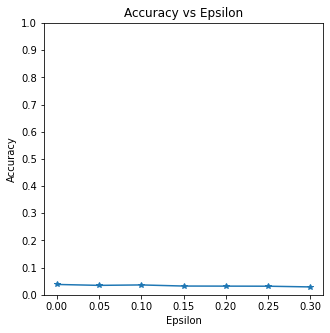

In [26]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

**샘플 적대적 예제들**

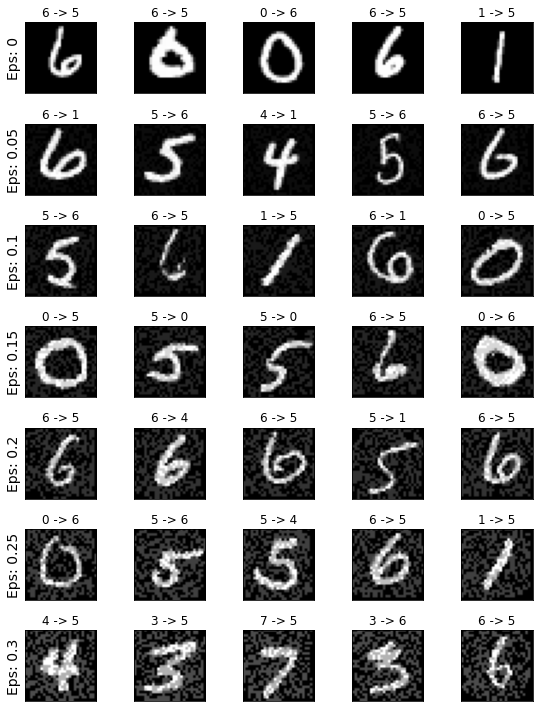

In [27]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()